In [1]:
import os
import time
print(os.environ['LSST_DDS_DOMAIN'])
os.environ['LSST_DDS_DOMAIN'] = 'auxtelpath'
print(os.environ['LSST_DDS_DOMAIN'])
from salpytools import salpylib 
import logging
logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] [%(levelname)s] [%(threadName)s]: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')
import subprocess
from astropy.io import fits
from matplotlib import pyplot as py
import numpy as np
%matplotlib inline

auxtelpath
auxtelpath


In [2]:
def grab_data_from_scp_string(fname):
    scp_from = fname.split('://')[1]
    scp_to = os.path.expanduser('~/data/')
    if not os.path.exists(scp_to):
        os.makedirs(scp_to)
    cmd = 'scp {} {}'.format(scp_from, scp_to)
    #print(cmd)
    proc = subprocess.run(cmd, shell=True, check=True)
    
    filename = scp_from.split('/')[-1]
    return(os.path.join(scp_to,filename))

In [3]:
component_list = ['calibrationElectrometer', 
                  'atMonochromator', 'sedSpectrometer']

In [4]:
sedSpectrometer = salpylib.DDSSubscriberContainer('sedSpectrometer')
calibrationElectrometer = salpylib.DDSSubscriberContainer('calibrationElectrometer')
atMonochromator = salpylib.DDSSubscriberContainer('atMonochromator')

#atMonochromator.Wavelength.wavelength
#calibrationElectrometer.SummaryState.summaryState

In [5]:
# want to create a class that captures all of the different components
# Need to declare its existance here
class SenderContainer():
    pass

In [6]:
sender = SenderContainer()
sender.sedSpectrometer = salpylib.DDSSend("sedSpectrometer")
sender.calibrationElectrometer = salpylib.DDSSend("calibrationElectrometer")
sender.atMonochromator = salpylib.DDSSend("atMonochromator")

In [7]:
# bring up the components into the enabled state
# can't query device state at this time
# start by going to standby, then disabled, then enabled
cmd_id = sender.sedSpectrometer.send_Command('start', start=True, settingsToApply='Default', wait_command=True)
cmd_id1 = sender.calibrationElectrometer.send_Command('start', settingsToApply='Default', wait_command=True)
cmd_id2 = sender.atMonochromator.send_Command('start', settingsToApply='Default', wait_command=True)

print(cmd_id, cmd_id1, cmd_id2)

(596516649, 303) (1189641421, -301) (1025202362, 303)


In [9]:
cmd_id1 = sender.calibrationElectrometer.send_Command('start', settingsToApply='Default', wait_command=True)
print(cmd_id1)

(1189641423, 303)


In [10]:
cmd_id = sender.sedSpectrometer.send_Command('enable', enable=True, wait_command=True)
# print(cmd_id)
cmd_id1 = sender.calibrationElectrometer.send_Command('enable', enable=True, wait_command=True)
#print(cmd_id1)
cmd_id2 = sender.atMonochromator.send_Command('enable', enable=True, wait_command=True)
print(cmd_id, cmd_id1, cmd_id2)

(1350490027, 303) (783368690, 303) (1102520059, 303)


Opening /home/saluser/data/testlamp1531780354.930020.fits
Wavelength of max Int.: 452.756591796875
Opening /home/saluser/data/testlamp1531780365.739674.fits
Wavelength of max Int.: 498.505859375


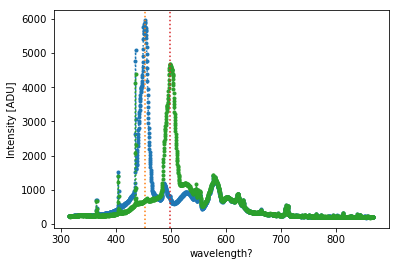

In [12]:
wavelength_arr=np.array([450, 500])
for wave in wavelength_arr:
    cmd_id = sender.atMonochromator.send_Command('updateMonochromatorSetup',gratingType=1,
                                             fontExitSlitWidth = 5.0, 
                                             fontEntranceSlitWidth = 5.0,
                                             wavelength = wave, wait_command=True)
    
    cmd_id2 = sender.calibrationElectrometer.send_Command('StartScanDt', 
                                                     electId=1, time=2, 
                                                     timeout=10, wait_command=True)
    
    # setup SED Spectrograph
    cmd_id = sender.sedSpectrometer.send_Command('captureSpectImage', imageType='test',
                                                 integrationTime=2, lamp='lamp',
                                                 wait_command=True)
    
    time.sleep(1)
    sedSpectrometer_fname=grab_data_from_scp_string(sedSpectrometer.LargeFileObjectAvailable.URL)
    electrometer_fname=grab_data_from_scp_string(calibrationElectrometer.LargeFileObjectAvailable.URL)


    # open sedSpectrometer data
    print('Opening %s' % sedSpectrometer_fname)
    hdu = fits.open(sedSpectrometer_fname)
    data =hdu[0].data.T
    
    mean = np.mean(data[1])
    std = np.std(data[1])

    py.plot(data[0],data[1],'.:')

    nmax = np.argmax(data[1])
    ylim = py.ylim()
    py.plot([data[0][nmax],data[0][nmax]],ylim,':')
    print('Wavelength of max Int.: {}'.format(data[0][nmax]))
    py.ylim(ylim)
    
py.xlabel('wavelength?')
py.ylabel('Intensity [ADU]')

In [17]:
# Setup Electrometer
cmd_id = sender.calibrationElectrometer.send_Command('StartScanDt', 
                                                     electId=1, time=5, 
                                                     timeout=10, wait_command=True)
print(cmd_id)
print(calibrationElectrometer.LargeFileObjectAvailable.URL)

(1350490028, 303)
scp://saluser@140.252.33.129:/home/saluser/ts_electrometer/ts_electrometeruserevents/Subprojects/ID1_1531518326.14246607.fits


In [54]:
# setup SED Spectrograph
cmd_id = sender.sedSpectrometer.send_Command('captureSpectImage', imageType='test', 
                                             integrationTime=5, lamp='lamp',
                                             wait_command=True)

In [19]:
print(sedSpectrometer.LargeFileObjectAvailable.URL)

scp://harini@140.252.32.244:/home/harini/TCS/SEDSpectrum/testlamp1531518336.873927.fits


In [47]:
fname=grab_data_from_scp_string(sedSpectrometer.LargeFileObjectAvailable.URL)
#print(fname)

## Now open Spectrometer Data

In [38]:
# open sedSpectrometer data
hdu = fits.open(fname)
data =hdu[0].data.T

In [39]:
#print(data)

[[ 314.97988892  315.27429199  315.56866455 ...,  866.68377686
   866.92504883  867.16625977]
 [ 213.          217.25        218.         ...,  190.25        192.5
   193.5       ]]


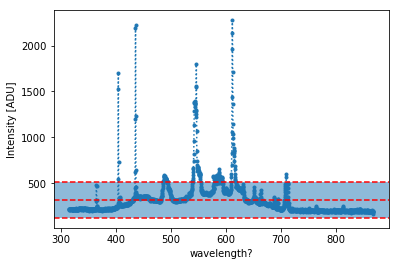

In [44]:
mean = np.mean(data[1])
std = np.std(data[1])

py.plot(data[0],data[1],'.:')

xlim = py.xlim()
py.fill_between(xlim,[mean-std,mean-std], [mean+std,mean+std],alpha=0.5)
py.plot(xlim, [mean-std,mean-std], 'r--')
py.plot(xlim, [mean,mean], 'r--')
py.plot(xlim, [mean+std,mean+std], 'r--')

py.xlim(xlim)
py.xlabel('wavelength?')
py.ylabel('Intensity [ADU]')

In [27]:
# use this to get the commands available
print(sender.atMonochromator.issueCommand.keys())

dict_keys(['CalibrateWavelength', 'ChangeLightIntensity', 'ChangeSlitWidth', 'ChangeWavelength', 'Power', 'PowerWhiteLight', 'SelectGrating', 'SetCoolingTemperature', 'disable', 'enable', 'enterControl', 'exitControl', 'standby', 'start', 'updateMonochromatorSetup'])


## Now open monochromator data

In [49]:
fname=grab_data_from_scp_string(calibrationElectrometer.LargeFileObjectAvailable.URL)
#print(fname)

In [50]:
# open fits data
hdu = fits.open(fname)
data =hdu[0].data.T

In [51]:
#print(data)

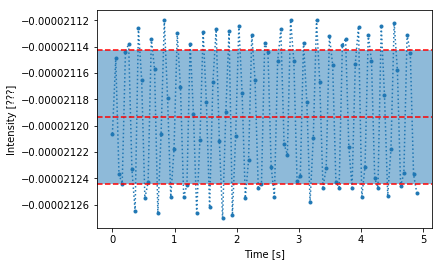

In [53]:
mean = np.mean(data[1])
std = np.std(data[1])

py.plot(data[0],data[1],'.:')

xlim = py.xlim()
py.fill_between(xlim,[mean-std,mean-std], [mean+std,mean+std],alpha=0.5)
py.plot(xlim, [mean-std,mean-std], 'r--')
py.plot(xlim, [mean,mean], 'r--')
py.plot(xlim, [mean+std,mean+std], 'r--')

py.xlim(xlim)
py.xlabel('Time [s]')
py.ylabel('Intensity [???]')